# XGBoost Model for Protein Localization

In [1]:
# install packages
!pip install -q accelerate biopython transformers evaluate datasets requests pandas wandb optuna -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 61.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) # to enable connection to the drive

Mounted at /content/gdrive


In [ ]:
drive_path = 'gdrive/MyDrive/Colab Notebooks/'

In [ ]:
# Extract sequences
from Bio import SeqIO
import pandas as pd
import matplotlib.pyplot as plt

d = {'id':[], 'seq':[], 'label':[]}
files = ['cyto.fasta.txt', 'mito.fasta.txt', 'nucleus.fasta.txt', 'other.fasta.txt', 'secreted.fasta.txt']
for i in range(len(files)):
  for seq_record in SeqIO.parse(open(drive_path+files[i]),'fasta'):
    d['id'].append(seq_record.id)
    d['seq'].append(''.join(seq_record.seq))
    d['label'].append(i)

In [ ]:
# Explore the data
df = pd.DataFrame(d)
df.head()

,id,seq,label
0,sp|Q4JIM5|ABL2_MOUSE,MGQQVGRVGEAPGLQQPQPRGIRGSSAARPSGRRRDPAGRTADAGF...,0
1,sp|P15891|ABP1_YEAST,MALEPIDYTTHSREIDAEYLKIVRGSDPDTTWLIISPNAKKEYEPE...,0
2,sp|P35609|ACTN2_HUMAN,MNQIEPGVQYNYVYDEDEYMIQEEEWDRDLLLDPAWEKQQRKTFTA...,0
3,sp|P05095|ACTNA_DICDI,MSEEPTPVSGNDKQLLNKAWEITQKKTFTAWCNSHLRKLGSSIEQI...,0
4,sp|Q9Y2D8|ADIP_HUMAN,MGDWMTVTDPGLSSESKTISQYTSETKMSPSSLYSQQVLCSSIPLS...,0


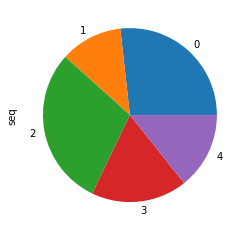

In [ ]:
# Plot label dostribution
df.groupby('label').count()['seq'].plot.pie()
plt.show()

## Feature Engineering

In [ ]:
from Bio.SeqUtils import ProtParam
from sklearn.decomposition import PCA
from itertools import product

def dipeptide_composition(sequence):
    dipeptides = [''.join(dp) for dp in product('ACDEFGHIKLMNPQRSTVWY', repeat=2)]
    composition = {}
    for dipeptide in dipeptides:
        count = sequence.count(dipeptide)
        composition[dipeptide] = count / (len(sequence) - 1)
    return composition

import math


def compute_features(sequence):
    protein_analyzer = ProtParam.ProteinAnalysis(sequence)
    molecular_weight = protein_analyzer.molecular_weight()
    aromaticity = protein_analyzer.aromaticity()
    instability_index = protein_analyzer.instability_index()
    isoelectric_point = protein_analyzer.isoelectric_point()
    secondary_structure_fraction = protein_analyzer.secondary_structure_fraction()
    amino_acid_percent = protein_analyzer.get_amino_acids_percent()
    flexibility = protein_analyzer.flexibility()
    gravy = protein_analyzer.gravy()
    charge_at_ph7 = protein_analyzer.charge_at_pH(7)
    molar_extinction_coefficient = protein_analyzer.molar_extinction_coefficient()

    feature_dict = {
        'molecular_weight': molecular_weight,
        'aromaticity': aromaticity,
        'instability_index': instability_index,
        'isoelectric_point': isoelectric_point,
        'helix_fraction': secondary_structure_fraction[0],
        'turn_fraction': secondary_structure_fraction[1],
        'sheet_fraction': secondary_structure_fraction[2],
        'gravy': gravy,
        'charge_at_ph7': charge_at_ph7,
        'molar_extinction_coefficient_reduced': molar_extinction_coefficient[0],
        'molar_extinction_coefficient_cystines': molar_extinction_coefficient[1]
    }
    # Sequence length
    feature_dict['sequence_length'] = len(sequence)

    # Local amino acid composition
    local_seq_start = sequence[:50]
    local_seq_end = sequence[-50:]
    local_pp_start =  ProtParam.ProteinAnalysis(local_seq_start)
    local_pp_end =  ProtParam.ProteinAnalysis(local_seq_end)
    for aa, comp_start in local_pp_start.get_amino_acids_percent().items():
        feature_dict[f'local_composition_start_{aa}'] = comp_start
    for aa, comp_end in local_pp_end.get_amino_acids_percent().items():
        feature_dict[f'local_composition_end_{aa}'] = comp_end

    dipeptide_comp = dipeptide_composition(sequence)
    for dipeptide, comp in dipeptide_comp.items():
        feature_dict[f'dipeptide_{dipeptide}'] = comp

    for aa, percent in amino_acid_percent.items():
        feature_dict[f'{aa}_percent'] = percent
    return feature_dict

def is_valid_sequence(sequence):
    standard_amino_acids = set('ACDEFGHIKLMNPQRSTVWY')
    return all(aa in standard_amino_acids for aa in sequence)

def extract_features(dataframe):
    features = []
    i=0
    for index, row in dataframe.iterrows():
        sequence = row['seq']
        if is_valid_sequence(sequence):
          feature_dict = compute_features(sequence)
          feature_dict['id'] = row['id']
          feature_dict['label'] = row['label']
          features.append(feature_dict)
        else:
          i+=1
    print(i)
    
    return pd.DataFrame(features)

output_df = extract_features(df)

# Create a DataFrame containing only dipeptide features
dipeptide_features = output_df.filter(like="dipeptide_", axis=1)

# Perform PCA with only 2 principal components on dipeptide features
pca = PCA(n_components=2)
principal_components = pca.fit_transform(dipeptide_features)

# Create a new DataFrame with the principal components
principal_df = pd.DataFrame(data=principal_components, columns=['principal_component_1', 'principal_component_2'])

# Drop the original dipeptide features from the output DataFrame
output_df = output_df.drop(dipeptide_features.columns, axis=1)

# Concatenate the principal components with the output DataFrame
output_df = pd.concat([output_df, principal_df], axis=1)

64


In [ ]:
import numpy as np
corr_matrix = output_df.corr().abs()

# The matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
sol.head(30)

df = output_df.drop(columns=['turn_fraction', 'molar_extinction_coefficient_cystines','molar_extinction_coefficient_reduced', 'sequence_length', 'C_percent'])

In [ ]:
corr_matrix = df.corr().abs()

# The matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))
sol.head(10)


helix_fraction           gravy                    0.729855
aromaticity              Y_percent                0.727869
                         F_percent                0.716739
K_percent                principal_component_1    0.712972
A_percent                principal_component_1    0.708133
sheet_fraction           principal_component_2    0.678301
local_composition_end_K  K_percent                0.669126
helix_fraction           principal_component_2    0.640699
L_percent                principal_component_2    0.626803
local_composition_end_A  A_percent                0.626645
dtype: float64

In [ ]:
df.groupby('label').mean()

,molecular_weight,aromaticity,instability_index,isoelectric_point,helix_fraction,sheet_fraction,gravy,charge_at_ph7,local_composition_start_A,local_composition_start_C,...,P_percent,Q_percent,R_percent,S_percent,T_percent,V_percent,W_percent,Y_percent,principal_component_1,principal_component_2
label,,,,,,,,,,,,,,,,,,,,,
0,74551.982139,0.075662,47.535344,6.716411,0.280378,0.259699,-0.463223,-7.075396,0.072643,0.015869,...,0.053727,0.045667,0.054141,0.083965,0.052579,0.059928,0.010472,0.028015,-0.003010,0.000620
1,42128.790059,0.083774,42.600264,8.385528,0.302492,0.257239,-0.307167,5.709928,0.083432,0.016821,...,0.049259,0.039699,0.058883,0.076520,0.052780,0.063887,0.012211,0.030086,-0.000411,-0.003597
2,69918.565558,0.069682,52.353587,7.284225,0.256054,0.250407,-0.627411,-1.905487,0.070093,0.015187,...,0.057484,0.047886,0.059449,0.091096,0.051543,0.053749,0.009320,0.026073,-0.004377,0.004869
3,47888.166275,0.090090,37.557622,6.999998,0.325365,0.275875,-0.123580,-3.222246,0.094725,0.010899,...,0.047045,0.038356,0.056593,0.063030,0.054428,0.071952,0.014931,0.034758,0.008675,-0.009968
4,34215.486952,0.088190,40.083554,7.158281,0.279495,0.224746,-0.268217,-3.668952,0.085336,0.043548,...,0.056225,0.036977,0.046552,0.074028,0.056490,0.060853,0.015117,0.033819,0.004308,0.004273


In [ ]:
# Final features
df.columns

Index(['molecular_weight', 'aromaticity', 'instability_index',
       'isoelectric_point', 'helix_fraction', 'sheet_fraction', 'gravy',
       'charge_at_ph7', 'local_composition_start_A',
       'local_composition_start_C', 'local_composition_start_D',
       'local_composition_start_E', 'local_composition_start_F',
       'local_composition_start_G', 'local_composition_start_H',
       'local_composition_start_I', 'local_composition_start_K',
       'local_composition_start_L', 'local_composition_start_M',
       'local_composition_start_N', 'local_composition_start_P',
       'local_composition_start_Q', 'local_composition_start_R',
       'local_composition_start_S', 'local_composition_start_T',
       'local_composition_start_V', 'local_composition_start_W',
       'local_composition_start_Y', 'local_composition_end_A',
       'local_composition_end_C', 'local_composition_end_D',
       'local_composition_end_E', 'local_composition_end_F',
       'local_composition_end_G', 'local_

# Hyperparameter Tuning

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, cross_val_score

# Define the models to be compared
models = {
    'XGBoost': XGBClassifier(),
}


# Define the evaluation metrics to be used for performance comparison
metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1 score': f1_score,
}

# Define the number of folds for the outer and inner cross-validation loops
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Define the objective function for the optimization
def objective(trial, model, X_train, y_train, inner_cv):
    if model == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 3, 9)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        
        clf = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
        
    score = cross_val_score(clf, X_train, y_train, cv=inner_cv, scoring='f1_weighted').mean()
    return score

def nested_cv(X, y, models, outer_cv, inner_cv, metrics):
    results = {}
    best_params = {}
    fitted_models = {}
    for model_name in models.keys():
        outer_results = []
        
        # outer cv loop
        for train_idx, test_idx in outer_cv.split(X, y):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            
            # Inner cv for hyperparameter tuning using Optuna
            sampler = TPESampler()
            study = optuna.create_study(direction='maximize', sampler=sampler)
            study.optimize(lambda trial: objective(trial, model_name, X_train, y_train, inner_cv), n_trials=20)
            
            # use the best parameters to fit the model directly on the fold's test set
            best_params[model_name] = study.best_params
            model = models[model_name]
            model.set_params(**study.best_params)
            fitted_models[model_name] = model.fit(X_train, y_train) # only keep the last fold
            
            # evaluate the model on the test set and compute the evaluation metrics
            y_pred = model.predict(X_test)
            model_results = {}
            for name, metric in metrics.items():
              if name=='F1 score' or name=='Precision' or name=='Recall':
                metric_value = metric(y_test, y_pred, average='weighted')
              else: 
                metric_value = metric(y_test, y_pred)
              model_results[name] = metric_value
            outer_results.append(model_results)
        results[model_name] = outer_results
    return results, best_params, fitted_models

results, best_params, fitted_models = nested_cv(X_train.to_numpy(), y_train.to_numpy(), models, outer_cv, inner_cv, metrics)

[I 2023-03-17 08:28:38,325] A new study created in memory with name: no-name-46bb3623-2206-4487-b800-cce88a4c5fef
[I 2023-03-17 08:29:47,443] Trial 0 finished with value: 0.6637623711233452 and parameters: {'n_estimators': 125, 'max_depth': 6, 'learning_rate': 0.11800923433711132}. Best is trial 0 with value: 0.6637623711233452.
[I 2023-03-17 08:30:41,895] Trial 1 finished with value: 0.6662102953990962 and parameters: {'n_estimators': 158, 'max_depth': 5, 'learning_rate': 0.13533699963290372}. Best is trial 1 with value: 0.6662102953990962.
[I 2023-03-17 08:31:29,773] Trial 2 finished with value: 0.6446452535758079 and parameters: {'n_estimators': 88, 'max_depth': 8, 'learning_rate': 0.040780834953909405}. Best is trial 1 with value: 0.6662102953990962.
[I 2023-03-17 08:32:20,554] Trial 3 finished with value: 0.6638358998552717 and parameters: {'n_estimators': 108, 'max_depth': 7, 'learning_rate': 0.1481212362197578}. Best is trial 1 with value: 0.6662102953990962.
[I 2023-03-17 08:32

In [ ]:
best_params

{'XGBoost': {'n_estimators': 159,
  'max_depth': 8,
  'learning_rate': 0.29409816014196694}}

In [ ]:
results

{'XGBoost': [{'Accuracy': 0.7010078387458006,
   'Precision': 0.7005682684861384,
   'Recall': 0.7010078387458006,
   'F1 score': 0.7004054464155465},
  {'Accuracy': 0.6858902575587906,
   'Precision': 0.6906438502401208,
   'Recall': 0.6858902575587906,
   'F1 score': 0.6876128619952879},
  {'Accuracy': 0.7038073908174692,
   'Precision': 0.7067885872857833,
   'Recall': 0.7038073908174692,
   'F1 score': 0.7048363006568085},
  {'Accuracy': 0.6756302521008404,
   'Precision': 0.6780048813813386,
   'Recall': 0.6756302521008404,
   'F1 score': 0.6764610136984917},
  {'Accuracy': 0.6901960784313725,
   'Precision': 0.6907781911481634,
   'Recall': 0.6901960784313725,
   'F1 score': 0.6891900241057722}]}

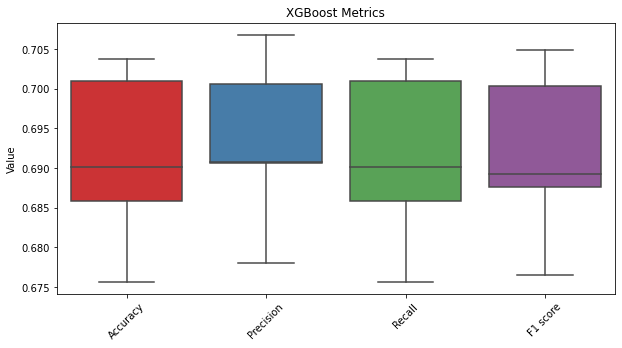

In [ ]:
import seaborn as sns

def plot_metrics_single_plot(model_name, model_data):
    """
    Plots a boxplot that compares the metrics side-by-side for the given model.

    Parameters
    ----------
    model_name : str
        The name of the model (e.g., "xgboost").
    model_data : list
        A list of dictionaries, where each dictionary contains a metric name and its values as a numpy array.
    """
    output_dict = {model_name: {}}
    
    for metric_dict in model_data:
        for metric_name, metric_value in metric_dict.items():
            if metric_name not in output_dict[model_name]:
                output_dict[model_name][metric_name] = []
            output_dict[model_name][metric_name].append(metric_value)

    metrics = list(output_dict[model_name].keys())

    # create the boxplot
    fig, ax = plt.subplots(figsize=(10, 5))
    values = [output_dict[model_name][metric] for metric in metrics]
    # sns.violinplot(data=values, inner="points", palette="Set1", bw=.2, ax=ax)
    sns.boxplot(data=values, palette="Set1", ax=ax)
    ax.set_xticklabels(metrics)
    ax.set_title(f"{model_name} Metrics")
    ax.set_ylabel("Value")
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

    return output_dict

model_name = 'XGBoost'
model_data = results[model_name]

d = plot_metrics_single_plot(model_name, model_data)


# Evaluate Model

In [ ]:
labels = ['cyto', 'mito', 'nucleus', 'other', 'secreted']

In [ ]:
X = output_df.drop(['id', 'label'], axis=1)
y = output_df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
m= XGBClassifier()
m.fit(X_train, y_train)
preds = m.predict(X_test)
print(f1_score(preds, y_test, average='weighted'))
print(accuracy_score(preds, y_test))
print(precision_score(preds, y_test, average='weighted'))
print(recall_score(preds, y_test, average='weighted'))
from sklearn.preprocessing import StandardScaler


0.6727047031176527
0.6738351254480287
0.6737533796836109
0.6738351254480287


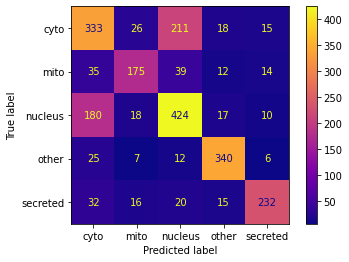

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, preds, labels=m.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
disp.plot(cmap='plasma')

plt.show()